# Import the Trained model

In [ ]:
!pip install ultralytics==8.0.196

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gE66dB5HoMJrh6P7OtPT")
project = rf.workspace("mohammadjalkhatib").project("chess_dataset_topview")
version = project.version(1)
dataset = version.download("yolov8")

In [ ]:
from ultralytics import YOLO

model = YOLO('best.pt')  # pretrained YOLOv8x model

In [ ]:
results = model.predict(source='/content/Chess_Dataset_TopView-1/test/images/IMG_20240310_213212_jpg.rf.dbab87c800b284bbf79ea153f8e73b8e.jpg', conf=0.25)


image 1/1 /content/Chess_Dataset_TopView-1/test/images/IMG_20240310_213212_jpg.rf.dbab87c800b284bbf79ea153f8e73b8e.jpg: 640x640 2 Black_Bishops, 1 Black_King, 2 Black_Knights, 5 Black_Pawns, 1 Black_Rook, 1 Chess_Board, 1 White_King, 2 White_Pawns, 1 White_Queen, 4876.2ms
Speed: 5.2ms preprocess, 4876.2ms inference, 32.0ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
results = model('/content/Chess_Dataset_TopView-1/test/images/IMG_20240310_213212_jpg.rf.dbab87c800b284bbf79ea153f8e73b8e.jpg')


image 1/1 /content/Chess_Dataset_TopView-1/test/images/IMG_20240310_213212_jpg.rf.dbab87c800b284bbf79ea153f8e73b8e.jpg: 640x640 2 Black_Bishops, 1 Black_King, 2 Black_Knights, 5 Black_Pawns, 1 Black_Rook, 1 Chess_Board, 1 White_King, 2 White_Pawns, 1 White_Queen, 5683.2ms
Speed: 2.9ms preprocess, 5683.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


# Transfer to FEN

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO


def predict_labels(image_path):
    # Initialize YOLO model
    model = YOLO('best.pt')

    # Perform object detection
    results = model(image_path)

def transfer_to_fen_notation(prediction):
    # Process results list
    for result in results:
        boxes = result.boxes  # Boxes object for bounding box outputs
        classes = boxes.cls   # Classes  for bounding boxs

        # boxes_np = result.boxes.xyxy.numpy()  # Convert Boxes object to NumPy array
        # classes_np = boxes.cls.numpy()  # Convert Classes object to NumPy array

    # Find the Chessboard label index
    cls_list = boxes.cls.tolist()
    chessboard_indx = 100
    for i in range (len(cls_list)):
        if cls_list[i] == 6.0:
            chessboard_indx = i

    # Finding the dimensions of the chessboard
    x_b, y_b, w_b, h_b = boxes.xywh.tolist()[chessboard_indx]

    # Each square width
    square_w = w_b / 8

    # Each square height
    square_h = h_b / 8

    # Calculating the distance to the edge of the picture
    x_0b, y_0b, w_0b, h_0b = boxes.xyxy.tolist()[chessboard_indx]
    dist_to_x_edge = x_0b
    dist_to_y_edge = y_0b

    # Now we find each piece and its location on the board
    pieces_location = [] # List of list for the pieces - [col, row]=[x, y]
    boxes_list = boxes.xywh.tolist()
    for i in range(len(boxes_list)):
        if cls_list[i] == 6.0: # Chessboard not one of the pieces
            continue
        x, y, w, h = boxes_list[i]
        col = x - dist_to_x_edge
        row = y - dist_to_y_edge
        pieces_location.append((col, row, cls_list[i]))


    # Now we change it from locations into order on the board
    # Define the number of rows and columns
    num_rows = 8
    num_cols = 8

    # Create an empty 2D array to store the pieces
    pieces_row_cols = []

    # Iterate over the pieces and their locations
    for i in range(len(pieces_location)):

        horz_dist, vert_dist, label =  pieces_location[i]
        # We start with the rows (x): a, b, c, d, e, f, g, h
        if 0 < vert_dist < square_h:
            row = 8  # We start with 8 because we go from top to bottom
        elif  square_h <= vert_dist < 2 * square_h:
            row = 7
        elif  2 * square_h <= vert_dist < 3 * square_h:
            row = 6
        elif  3 * square_h <= vert_dist < 4 * square_h:
            row = 5
        elif  4 * square_h <= vert_dist < 5 * square_h:
            row = 4
        elif  5 * square_h <= vert_dist < 6 * square_h:
            row = 3
        elif  6 * square_h <= vert_dist < 7 * square_h:
            row = 2
        elif  7 * square_h <= vert_dist < 8 * square_h:
            row = 1

        # Now we find the cols (y): 1, 2, 3, 4, 5, 6, 7, 8
        if 0 < horz_dist < square_w:
            col = 'a'
        elif  square_w <= horz_dist < 2 * square_w:
            col = 'b'
        elif  2 * square_w <= horz_dist < 3 * square_w:
            col = 'c'
        elif  3 * square_w <= horz_dist < 4 * square_w:
            col = 'd'
        elif  4 * square_w <= horz_dist < 5 * square_w:
            col = 'e'
        elif  5 * square_w <= horz_dist < 6 * square_w:
            col = 'f'
        elif  6 * square_w <= horz_dist < 7 * square_w:
            col = 'g'
        elif  7 * square_w <= horz_dist < 8 * square_w:
            col = 'h'

        pieces_row_cols.append((row, col, label))

    class_names = result.names

    #write the labels in FEN format
    notation_Mapping = {
        'Black_Bishop': 'b', 'Black_King': 'k', 'Black_Knight': 'n', 'Black_Pawn': 'p',
        'Black_Queen': 'q', 'Black_Rook': 'r', 'White_Bishop': 'B', 'White_King': 'K',
        'White_Knight': 'N', 'White_Pawn': 'P', 'White_Queen': 'Q', 'White_Rook': 'R'
    }

    #this loop will help us get the results that we need in a tuple (row, col, label)
    pieces_with_cord = []
    for i in range(len(pieces_row_cols)):
        row, col, label = pieces_row_cols[i]
        pieces_with_cord.append((row, col, notation_Mapping[class_names[label]]))

    #We will map
    fen = []
    for i in range(8):
        fen.append([])
        for j in range(8):
            fen[i].append('-')
            col_map = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}

    for i in range(len(pieces_with_cord)):
        row, col, piece = pieces_with_cord[i]
        fen[(8 - row)][col_map[col]]  = piece

    fen_notation = ""
    counter = 0
    for i in range(len(fen)):
        for j in range(len(fen[i])):
            if fen[i][j] == '-':
                counter += 1
            else:
                if counter != 0:
                    fen_notation += str(counter)

                counter = 0
                fen_notation += fen[i][j]

        if counter != 0:
            fen_notation += str(counter)

        counter = 0
        fen_notation += "/"

    fen_notation = fen_notation[:-1]
    fen_notation += " b - - 0 1"

    return fen_notation


In [95]:
image_path = '/content/Chess_Dataset_TopView-1/test/images/IMG_20240310_165829_jpg.rf.2d87379c4eea58f9bc06c617bd53d8d2.jpg'
predictions = predict_labels(image_path)


image 1/1 /content/Chess_Dataset_TopView-1/test/images/IMG_20240310_165829_jpg.rf.2d87379c4eea58f9bc06c617bd53d8d2.jpg: 640x640 2 Black_Bishops, 1 Black_King, 2 Black_Knights, 7 Black_Pawns, 1 Black_Queen, 2 Black_Rooks, 1 Chess_Board, 2 White_Bishops, 1 White_King, 2 White_Knights, 7 White_Pawns, 1 White_Queen, 2 White_Rooks, 4710.5ms
Speed: 4.0ms preprocess, 4710.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


In [96]:
fen_notation  = transfer_to_fen_notation(predictions) # fen_notation
print(fen_notation)

rnbq1rk1/ppp1ppbp/5np1/8/2QP1B2/2N2N2/PP2PPPP/R3KB1R b - - 0 1



0: 640x640 2 Black_Bishops, 1 Black_King, 2 Black_Knights, 7 Black_Pawns, 1 Black_Queen, 2 Black_Rooks, 1 Chess_Board, 2 White_Bishops, 1 White_King, 2 White_Knights, 7 White_Pawns, 1 White_Queen, 2 White_Rooks, 6381.9ms
Speed: 3.1ms preprocess, 6381.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


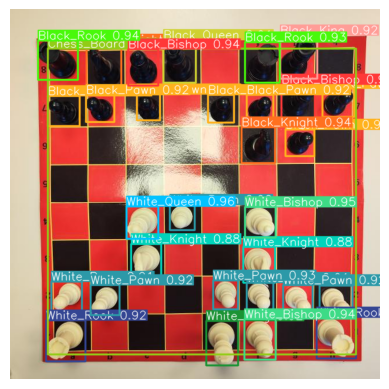

In [97]:
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt


# Run inference on test image
results = model(['/content/Chess_Dataset_TopView-1/test/images/IMG_20240310_165829_jpg.rf.2d87379c4eea58f9bc06c617bd53d8d2.jpg'])  # results list

# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Display the results using matplotlib
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

    # # Save results to disk
    # r.save(filename=f'results{i}.jpg')

# Chess Libraries

In [ ]:
!pip install chess python-lichess

In [ ]:
import lichess.api
from lichess.format import SINGLE_PGN

In [ ]:
user = "DrNykterstein" # Magnus Carlsen! You can change this to any lichess user.

In [ ]:
pgn = lichess.api.user_games(user, max=1, format=SINGLE_PGN)
print(pgn)

In [ ]:
import chess
import chess.pgn
print(chess.__version__)

1.10.0


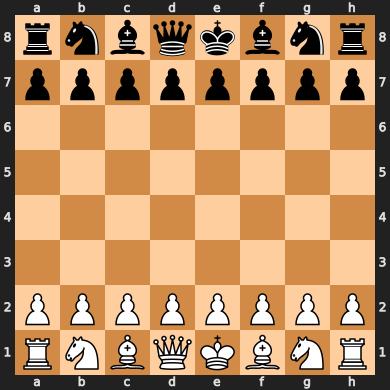

In [ ]:
board = chess.Board()
board

In [111]:
board.fen()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

# Using Stockfish Engine

In [65]:
#import the file from machine and unzip it

import tarfile
import os

# Path to the uploaded tar file
tar_file_path = '/content/stockfish-LINUX-ubuntu-x86-64-avx2.tar'  # Update with your file path

# Directory to extract the contents
extracted_dir = '/content/stockfish/'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Extract the contents of the tar file
with tarfile.open(tar_file_path, 'r:') as tar_ref:
    tar_ref.extractall(extracted_dir)

# List the extracted files
extracted_files = os.listdir(extracted_dir)
print("Extracted files:", extracted_files)


Extracted files: ['stockfish']


In [103]:
def next_move(fen_notation):

    #load the model
    stockfish = Stockfish(path="/content/stockfish/stockfish/stockfish-ubuntu-x86-64-avx2")
    #Determine the parameters of the model
    {
    "Debug Log File": "",
    "Contempt": 0,
    "Min Split Depth": 0,
    "Threads": 1, # More threads will make the engine stronger, but should be kept at less than the number of logical processors on your computer.
    "Ponder": "false",
    "Hash": 16, # Default size is 16 MB. It's recommended that you increase this value, but keep it as some power of 2. E.g., if you're fine using 2 GB of RAM, set Hash to 2048 (11th power of 2).
    "MultiPV": 1,
    "Skill Level": 20,
    "Move Overhead": 10,
    "Minimum Thinking Time": 20,
    "Slow Mover": 100,
    "UCI_Chess960": "false",
    "UCI_LimitStrength": "false",
    "UCI_Elo": 1350
    }
    stockfish.set_fen_position(fen_notation)
    return stockfish.get_best_move()


In [173]:
move = next_move(fen_notation)
print(move)

c8e6


# Mapping Best next move into physical directions for the Qarm to control

In [150]:
#The pick and place in the simulink file has to take an array that has the values and the locations for the 64 squares PLUS the grave Yard

# Those are the variables that control the movement:
# home = [0.45; 0; 0.49];
# pick_high = [0.00; -0.45; 0.15];
# pick = [0.00; -0.45; 0.03];
# place = [0.00; 0.45; 0.15];

# waypoints = [pick, pick, home, place, place, home]' ;

In [155]:
import pandas as pd
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/Placement of pieces_csv.csv')

In [176]:
def pick_place_list(move):

    move_from = move[:2]
    move_to = move[2:]

    col_name = move_from[0]  # Extract the column name ('a' from 'a8')
    row_name = int(move_from[1])  # Extract the row number (8 from 'a8')
    # Access the data corresponding to the specified row and column
    pick = df.loc[(df['Col'] == col_name) & (df['Row'] == row_name)]['Pick'].tolist()[0]
    place = df.loc[(df['Col'] == col_name) & (df['Row'] == row_name)]['Place'].tolist()[0]
    home = df.loc[(df['Col'] == col_name) & (df['Row'] == row_name)]['Home'].tolist()[0]

    # Create the list of waypoints
    waypoints = [pick, pick, home, place, place, home]

    # print(f'pick: {pick}, place: {place}, home: {home},\nWaypoints: {waypoints}')
    return (pick, place)

In [177]:
pick_place_list(move)

('[0.271875; -0.04375; 0.45]', '[0.271875; -0.04375; 0.45]')

# Sending the location of the pieces to Simulink file to acuate the move

In [179]:
!pip install matlab

  Preparing metadata (setup.py) ... done
  Created wheel for matlab: filename=matlab-0.1-py3-none-any.whl size=1156 sha256=e1a190cc484dd3623ec99c36f91c48db2f68c599dcbe722aaf1afa8813a61417
  Stored in directory: /root/.cache/pip/wheels/d1/d3/76/5314058ee22e7957a18eec0291788462f1df178bb08223bdd2
Successfully built matlab
